# Projet GouvImmo: Modèle de régression linéaire optimisé

Ce jeu de données présente les ventes de biens immobiliers de la région Ile De France entre 2019 et 2021 (IDF_2019_to_2021_v3.csv). 
Le data set comporte essentiellement des données géographiques liées à l'adresse, mais aussi quelques éléments concernant la surface en m2 et le nombre de pièces notamment.

Le modèle développé ci-dessous est un modèle de régression linéaire qui a pour objectif de déterminer notre cible, à savoir, la valeur foncière.


In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats      
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error            # MSE
from sklearn.metrics import mean_absolute_error           # MAE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import  SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import  SelectKBest, f_regression
import xgboost as xgb
from xgboost import XGBRegressor

# Importation des librairies et du data set :

In [ ]:
# Lecture du fichier CSV
df = pd.read_csv('IDF_2019_to_2021_v3.csv')

In [ ]:
# Jeu de données original : 
df.shape

(364462, 32)

In [ ]:
# le jeu de données ne contient aucun doublons
df.duplicated().sum()

0

In [ ]:
# Suppression des lignes latitude et longitude contenant des NaN
print('latitude et longitude: Nombre de lignes sans NaN :', len(df[(df['latitude'].notna() & df['longitude'].notna())]))
df = df[(df['latitude'].notna() & df['longitude'].notna())]

latitude et longitude: Nombre de lignes sans NaN : 363029


In [ ]:
# Suppression des variables non nécessaires 
# Les variables de prix au m² ont été créées à partir de la valeur foncière (target), 
# il n'est pas pertinent de les conserver dans le modèle
# Les variables catégorielles sont aussi retirées.
# Par la suite, nous allons developé un modèle polynomial de niveau 3. 
# Nous devons retirer le code commune afin de ne pas alourdir la base de données (sinon, c'est impossible)
df1 =df.drop(['id_mutation','date_mutation','nature_mutation','adresse_suffixe','adresse_nom_voie',
             'adresse_code_voie','code_postal','nom_commune','id_parcelle', 'type_bien', 'section_cadastrale','adresse_numero','longitude',
             'latitude','prix_m²','prix_m²_moy_ca','prix_m²_moy_co',], axis = 1)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363029 entries, 0 to 364461
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   valeur_fonciere            363029 non-null  float64
 1   numero_disposition         363029 non-null  float64
 2   code_commune               363029 non-null  int64  
 3   code_departement           363029 non-null  int64  
 4   nombre_lots                363029 non-null  int64  
 5   surface_reelle_bati        363029 non-null  float64
 6   nombre_pieces_principales  363029 non-null  float64
 7   surface_terrain            363029 non-null  float64
 8   Appartement                363029 non-null  int64  
 9   Dépendance                 363029 non-null  int64  
 10  Maison                     363029 non-null  int64  
 11  terrains_a_batir           363029 non-null  int64  
 12  terrains_autre             363029 non-null  int64  
 13  annee                      36

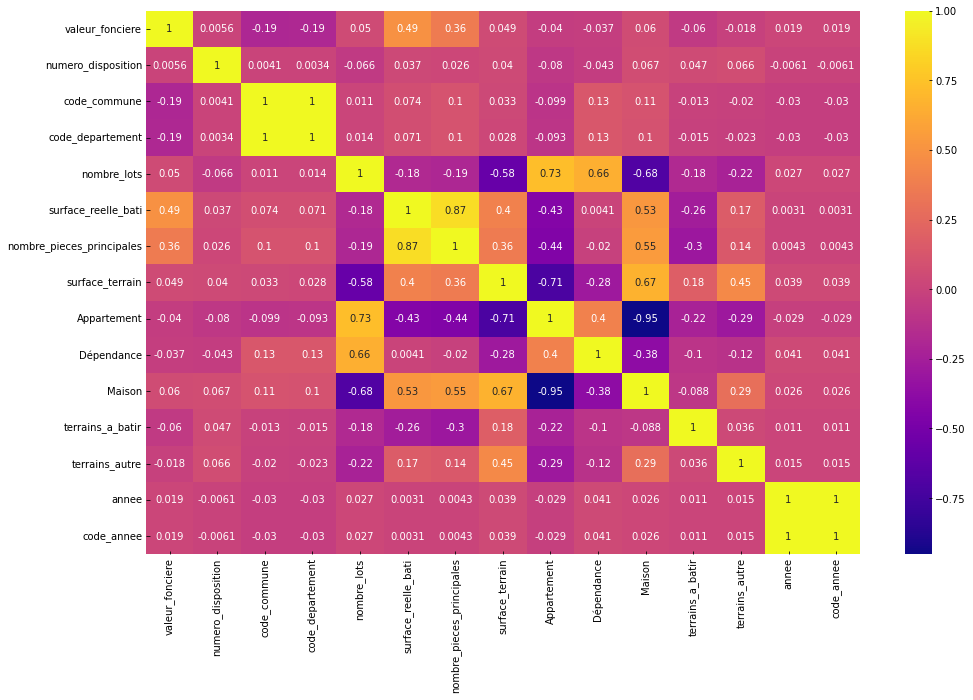

In [ ]:
# Tableau de corrélations des variables numériques
plt.figure(figsize=(16, 10))
sns.heatmap(df1.corr(), annot=True, cmap='plasma');

La valeur cible 'valeur foncière' est corrélée positivement avec la surface réélle du bati et le nombre de pièces

# Preprocessing

Dichotomisation de la seule variable 'object' à savoir le code commune ainsi que le code de département


In [ ]:
df2= pd.get_dummies(df1, columns=['code_departement','code_commune'])

In [ ]:
df2.dtypes.value_counts()

uint8      1281
int64         8
float64       5
dtype: int64

Nous avons bien uniquement des variables numériques

# Preparation des données

Définition de la target et des features

In [ ]:
X, y = df2.drop("valeur_fonciere", axis=1), df2['valeur_fonciere']

Séparation des données en un ensemble d'apprentissage et de test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=789)

Standardisation des variables

In [ ]:
scaler = StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train.head()

,numero_disposition,nombre_lots,surface_reelle_bati,nombre_pieces_principales,surface_terrain,Appartement,Dépendance,Maison,terrains_a_batir,terrains_autre,...,code_commune_95652,code_commune_95656,code_commune_95658,code_commune_95660,code_commune_95675,code_commune_95676,code_commune_95678,code_commune_95680,code_commune_95682,code_commune_95690
0,-0.072884,0.270260,-0.627443,-0.727836,-0.465784,0.649066,-0.718366,-0.617960,-0.143102,-0.208311,...,-0.02235,-0.005567,-0.007873,-0.008504,-0.014962,-0.006428,-0.010332,-0.034686,-0.001856,-0.00491
1,-0.072884,-1.254258,0.563994,0.628871,1.611897,-1.540674,-0.718366,1.618228,-0.143102,-0.208311,...,-0.02235,-0.005567,-0.007873,-0.008504,-0.014962,-0.006428,-0.010332,-0.034686,-0.001856,-0.00491
2,-0.072884,0.270260,-0.849105,-0.727836,-0.465784,0.649066,0.931536,-0.617960,-0.143102,-0.208311,...,-0.02235,-0.005567,-0.007873,-0.008504,-0.014962,-0.006428,-0.010332,-0.034686,-0.001856,-0.00491
3,-0.072884,0.270260,0.453162,0.628871,-0.465784,0.649066,0.931536,-0.617960,-0.143102,-0.208311,...,-0.02235,-0.005567,-0.007873,-0.008504,-0.014962,-0.006428,-0.010332,-0.034686,-0.001856,-0.00491
4,-0.072884,0.270260,-0.378072,-0.049483,-0.465784,0.649066,-0.718366,-0.617960,-0.143102,-0.208311,...,-0.02235,-0.005567,-0.007873,-0.008504,-0.014962,-0.006428,-0.010332,-0.034686,-0.001856,-0.00491


In [ ]:
print('Nombre de lignes / colonnes de la base Train (X puis y): ', X_train.shape, y_train.shape)
print('Nombre de lignes / colonnes de la base Test (X puis y): ', X_test.shape, y_test.shape)

Nombre de lignes / colonnes de la base Train (X puis y):  (290423, 1293) (290423,)
Nombre de lignes / colonnes de la base Test (X puis y):  (72606, 1293) (72606,)


# Premier modèle, test avec données de base

Instanciation d'un régresseur lr de la classe LinearRegression. Puis ajustement du modèle à X_train & y_train

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_train_predict = lr.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)
mae = mean_absolute_error(y_train, y_train_predict)
print('La performance du modèle sur la base d apprentissage: ')
print('   l erreur quadratique moyenne est {}'.format(rmse))
print('   l erreur absolue moyenne est {}'.format(mae))
print('   le score R2 est {}'.format(r2))
print('\n')

La performance du modèle sur la base d apprentissage: 
   l erreur quadratique moyenne est 167606.3426698591
   l erreur absolue moyenne est 107084.11648930608
   le score R2 est 0.6665052153436184




In [ ]:
y_test_predict = lr.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)
mae = mean_absolute_error(y_test, y_test_predict)
print('La performance du modèle sur la base de test: ')
print('   l erreur quadratique moyenne est {}'.format(rmse))
print('   l erreur absolue moyenne est {}'.format(mae))
print('   le score R2 est {}'.format(r2))
print('\n')

La performance du modèle sur la base de test: 
   l erreur quadratique moyenne est 669966976168047.6
   l erreur absolue moyenne est 4914640733667.58
   le score R2 est -5.329330721270238e+18




En première instance, le modèle de regression linéaire ne semble pas fonctionner.
En effet, le coefficient de détermination nous montre que le modèle linéaire insuffisament capable d'estimer le prix des biens en IdF

# Test avec SelectKBest
Essayons de ne sélectionner que les variables les plus pertinentes pour ce modèle

In [ ]:
sk=SelectKBest(f_regression, k=26)
sk.fit(X, y)
df_kb=pd.DataFrame(data=sk.get_support(), index=X.columns)

In [ ]:
out=df_kb[df_kb[0]==False].index
X_train_KB=X_train.drop(out, axis=1)
X_test_KB=X_test.drop(out, axis=1)

In [ ]:
lr_KB = LinearRegression()
lr_KB.fit(X_train_KB, y_train)

LinearRegression()

In [ ]:
y_train_predict_KB = lr_KB.predict(X_train_KB)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict_KB)))
r2 = r2_score(y_train, y_train_predict_KB)
mae = mean_absolute_error(y_train, y_train_predict_KB)
print('La performance du modèle sur la base d apprentissage')
print('   l erreur quadratique moyenne est {}'.format(rmse))
print('   l erreur absolue moyenne est {}'.format(mae))
print('   le score R2 est {}'.format(r2))
print('\n')

La performance du modèle sur la base d apprentissage
   l erreur quadratique moyenne est 182518.42977414487
   l erreur absolue moyenne est 120624.31481399946
   le score R2 est 0.6045226682471694




In [ ]:
y_test_predict_KB = lr_KB.predict(X_test_KB)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict_KB)))
r2 = r2_score(y_test, y_test_predict_KB)
mae = mean_absolute_error(y_test, y_test_predict_KB)
print('La performance du modèle sur la base de test')
print('   l erreur quadratique moyenne est {}'.format(rmse))
print('   l erreur absolue moyenne est {}'.format(mae))
print('   le score R2 est {}'.format(r2))
print('\n')

La performance du modèle sur la base de test
   l erreur quadratique moyenne est 183009.12884907736
   l erreur absolue moyenne est 120642.44770131238
   le score R2 est 0.6023404769917702




En selectionnant 2% variables les plus pertinentes de notre jeu de données, le modèle n'est en capacité de déterminer les prix des biens qu'à hauteur de 60%. Bien que ce résultat soit faible, il ne présente pas d'overfitting 

# test avec XGB 
Optimisation

In [ ]:
xg_reg = XGBRegressor()
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [ ]:
y_pred_trainXG = xg_reg.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_pred_trainXG)))
r2 = r2_score(y_train, y_pred_trainXG)
print('La performance du modèle sur la base d apprentissage')
print('  l erreur quadratique moyenne est {}'.format(rmse))
print('  le score R2 est {}'.format(r2))
print('\n')

La performance du modèle sur la base d apprentissage
  l erreur quadratique moyenne est 117114.74302425493
  le score R2 est 0.8371711756205742




In [ ]:
y_pred_testXG = xg_reg.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_testXG)))
r2 = r2_score(y_test, y_pred_testXG)
print('La performance du modèle sur la base de test')
print('   l erreur quadratique moyenne est {}'.format(rmse))
print('   le score R2 est {}'.format(r2))
print('\n')

La performance du modèle sur la base de test
   l erreur quadratique moyenne est 125566.92357431857
   le score R2 est 0.8127954552379905




Les résultats grâce au XGB sont nettement meilleurs. De plus, ils ne présentent pas d'overfitting

# Visuels : prédictions

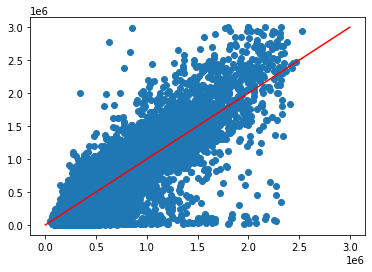

In [ ]:
pred_testXG = xg_reg.predict(X_test)
plt.scatter(pred_testXG, y_test)
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), c="red");

De manière plus graphique, les points sont pour certains proches de la droite, mais pour une grande partie, ils sont bien éloignés. Signe que les prédictions de ce modèle sont mitigées

# Visuels : résidus

Lorsque l'on regarde les résidus en fonction de la variable cible, nous constatons que les points semblent être répartis de manière uniforme autour de la droite

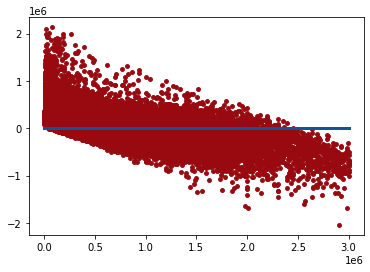

In [ ]:
pred_train_XG = xg_reg.predict(X_train)
residus = y_pred_trainXG - y_train

plt.scatter(y_train, residus, color='#980a10', s=15)
plt.plot((y_train.min(), y_train.max()), (0, 0), lw=3, color='#0a5798')

# Visuels: QQ-Plot des résidus

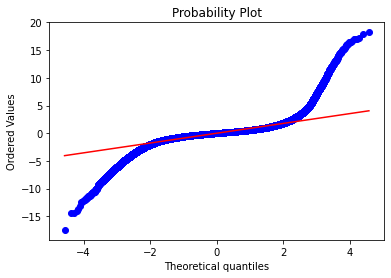

In [ ]:
residus_norm = (residus-residus.mean())/residus.std()
stats.probplot(residus_norm, plot=plt)
plt.show();

Le QQ plot présente une courbe en 'S' qui laisse penser qu'il y a des biais dans notre base, signifiant également qu'il y a beaucoup plus de données dans les extrémités que dans le centre de la distribution (prix de vente très élevés)